In [1]:
############
# Packages #
############
import time as t
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import scipy as sp
import random
from numba import jit
from typing import Dict, Union, List, Tuple, Any, Callable, Optional
import matplotlib.pyplot as plt

### Initialize parameters

Firstly, let's comput the initialization of the parameters

In [2]:
def compute_X(T, k, rho):
    """Compute matrix of xt observations

    Args:
        T (int): number of observations
        k (int): number of xt predictors
        rho (float): Toeplitz correlation parameter

    Returns:
        np.array: dimensions T*k
    """
    cov_matrix=np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            cov_matrix[i,j]=rho**np.abs(i-j)
    return np.random.multivariate_normal([0]*k, cov_matrix, T)

def compute_U(T, l):
    """Compute matrix of ut observations

    Args:
        T (int): number of observations
        l (int): number of ut predictors

    Returns:
        int: 0
    """
    if l==0:
        return 0
    else:
        pass
        
def compute_vx(X):
    """Compute mean estimated variance of xt predictors

    Args:
        X (np.array): matrix of xt predictors

    Returns:
        float: mean estimated variance of xt predictors
    """
    return np.mean(np.var(X,axis=0))

def sample_beta(k, s, seed=None):
    """Sample of beta vector of dimensions 1*k

    Args:
        k (int): number of predictors
        s (int): number of non-zero elements of beta
        seed (int, optional): random seed

    Returns:
        np.array: dimensions 1*k
    """
    if seed is not None:
        np.random.seed(seed=seed)
    beta=np.zeros(k)
    index_normal_distribution=np.random.choice(len(beta), size=s, replace=False)
    beta[index_normal_distribution] = np.random.normal(loc=0, scale=1, size=s)
    return beta

def sample_phi(l):
    """Sample phi prior

    Args:
        l (int): number of ut predictors

    Returns:
        int or np.array: phi samples
    """
    if l==0:
        return 0
    else:
        return np.random.uniform(0,1, size=l)

def compute_Z(beta):
    """Compute z_1,...,z_k

    Args:
        beta (np.array): random vector beta

    Returns:
        np.array: dimensions1*k
    """
    Z=beta
    Z[Z!=0]=1
    return Z

def compute_sigma2(Ry, beta, X):
    """ Compute sigma2
    Args:
        Ry (float): pourcentage of explained variance
        beta (np.array): random vector beta
        X (np.array): matrix of xt predictors

    Returns:
        float: dimensions 1*1
    """
    return (1/Ry-1)*np.mean(np.square(X @ beta))

def sample_R2(A,B, seed=None):
    """Sample R^2 according to a beta distribution

    Args:
        A (float): shape parameter
        B (float): shape parameter
        seed (int, optional): random seed

    Returns:
        float: R^2 random variable
    """
    if seed is not None:
        np.random.seed(seed=seed)

    return np.random.beta(A,B)

def sample_q(a,b, seed=None):
    """Sample q according to a beta distribution

    Args:
        a (float): shape parameter
        b (float): shape parameter
        seed (int, optional): random seed
    Returns:
        float: q random variable
    """
    if seed is not None:
        np.random.seed(seed=seed)

    return np.random.beta(a,b)

@jit(nopython=True)
def compute_gamma2(R2, q, k, vx):
    """Compute gamma^2 by inverting the R^2 function

    Args:
        R2 (float): R^2 random variable
        q (float): q random variable
        k (int): number of xt predictors
        vx (float): mean estimated variance of xt predictors

    Returns:
        float: gamma^2 random variable
    """
    return R2/((1-R2)*q*k*vx)

def sample_epsilon(T, sigma2, seed=None):
    """Sample epsilon_1,...,epsilon_T

    Args:
        T (int): number of observations
        sigma2 (float): sigma2 previously sampled
        seed (int, optional): random seed

    Returns:
        np.array: dimensions 1*T
    """
    if seed is not None:
        np.random.seed(seed=seed)
        
    return np.random.normal(loc=0, scale=sigma2, size=T)

def compute_Y(X, beta, epsilon):
    """Compute y_1,...,y_T

    Args:
        X (np.array): matrix of xt predictors
        beta (np.array): random vector beta
        epsilon (np.array): vector of epsilon_1,...,epsilon_T

    Returns:
        np.array: dimensions 1*T
    """
    return X@beta + epsilon


### Final function
def init_parameters(T, k, l, rho, s, Ry, a, b, A, B, standardized_X, seed=None):
    """
    Initialize parameters for a given simulation.

    Args:
        seed (int): Seed for reproducibility.
        T (int): Number of observations.
        k (int): Number of covariates.
        l (int): Number of latent variables.
        rho (float): Correlation parameter.
        s (float): Scaling parameter.
        Ry (float): Response variance.
        a (float): Shape parameter for gamma2.
        b (float): Shape parameter for gamma2.
        A (float): Shape parameter for q.
        B (float): Shape parameter for q.
        seed (int, optional): random seed.

    Returns:
        dict: Dictionary containing initialized parameters.
    """
    X=compute_X(T=T, k=k, rho=rho)
    if standardized_X:
        X = (X-np.mean(X, axis=0))/np.std(X, axis=0)

    dct = {
        "X" : X,
        "U": compute_U(T=T, l=l),
        "beta": sample_beta(k=k, s=s, seed=seed),
        "phi": sample_phi(l=l),
        "q": sample_q(a,b, seed=seed)
    }
    dct["R2"] = sample_R2(A,B, seed=seed)
    dct["gamma2"]=compute_gamma2(R2=dct["R2"], q=dct["q"], k=k, vx=compute_vx(dct["X"]))
    dct["Z"]=compute_Z(beta=dct["beta"])
    dct["sigma2"] = compute_sigma2(Ry=Ry, beta=dct["beta"], X=dct["X"])
    dct["epsilon"] = sample_epsilon(T=T, sigma2=dct["sigma2"], seed=seed)
    dct["Y"]=compute_Y(X=dct["X"], beta=dct["beta"], epsilon=dct["epsilon"])
    return dct

### Vectorization

In order to take advantage of the processor architecture, we're reducing ourselves to matrix manipulation and using just-in-time compilation by numba. So we're going to group all the information together in an array called data.

In [3]:
def vectorize_data(dct: Dict[str, np.ndarray], 
                   T: int, 
                   k: int, 
                   l: float, 
                   a: float, 
                   b: float,
                   A: float, 
                   B: float,
                   seed: int = None) -> np.ndarray:
    """
    Vectorize data from a dictionary and additional parameters.

    Parameters:
        dct (Dict[str, np.ndarray]): Dictionary containing data arrays.
        T (int): Number of time points.
        k (int): Number of components.
        l (float): Some parameter.
        a (float): Some parameter.
        b (float): Some parameter.
        A (float): Some parameter.
        B (float): Some parameter.
        seed (int, optional): random seed.

    Returns:
        np.ndarray: Vectorized data array.
    """
    
    data = np.zeros((k+3, T))
    
    data[0,0]=k
    data[0,1]=l
    data[0,2]=a
    data[0,3]=b
    data[0,4]=A
    data[0,5]=B
    data[0,6]=seed
    
    data[0,7]=compute_vx(dct["X"])
    data[0,8]=dct["R2"]
    data[0,9]=dct["q"]
    data[0,10]=dct["gamma2"]
    data[0,11]=dct["sigma2"]
    
    data[1,:]=dct["Y"]
    data[2,:k] = dct["Z"]
    data[2,k:] = dct["beta"]
    data[3:,:] = dct["X"].T
    
    return data

### (I). Draw from the conditional posterior of $(R^2, q)$

After discretizing the support of $(R^2, q)$, we use the inverse transform sampling method to simulate the a posteriori distribution of the pair of variables. Some stabilisation tricks were necessary to avoid numerical errors, such as switching to the logarithm. In addition, we can deduce the marginal distribution, a posteriori of q, by summing the joint distribution a posteriori of $(R^2, q)$ over the support of $R^2$. This step will allow us to compute the theoretical a posteriori median of q in order to illustrate the convergence results.

In [4]:
@jit(nopython=True)
def R2_q_flatted_grid(grid: np.ndarray) -> np.ndarray:
    """
    Flatten a 2D grid of parameters (grid) into a 2D array where each row
    represents a pair of parameters (R2, q).

    Parameters:
        grid (np.ndarray): 1D array representing a 2D grid of parameters.
s
    Returns:
        np.ndarray: 2D array with two columns representing pairs of parameters (R2, q).
    """
    n_pas = len(grid)
    R_q = np.zeros((n_pas**2, 2))
    for i in range(n_pas):
        for j in range(n_pas):
            R_q[i*n_pas+j,0] = grid[i]
            R_q[i*n_pas+j,1] = grid[j]
    return R_q

@jit(nopython=True)
def get_R2_q_grid() -> np.ndarray:
    """
    Generate a 2D grid of parameters (R2, q) with specified discretization.

    Returns:
        np.ndarray: 2D array with two columns representing pairs of parameters (R2, q).
    """
    arr0 = np.arange(0.001,0.101,0.001) # does not start at 0 because division by 0 otherwise
    arr1 = np.arange(0.11,0.91,0.01)
    arr2 = np.arange(0.901,1,0.001)
    discretization =  np.concatenate((arr0, arr1, arr2), axis=0)
    return R2_q_flatted_grid(discretization)

def get_R2_q_densities(data: np.ndarray, grid: np.ndarray) -> np.ndarray:
    """
    Calculate densities for a 2D parameter grid (R2, q) given data.

    Args:
        data (np.ndarray): Array containing the data.
        grid (np.ndarray): 2D array representing the parameter grid.

    Returns:
        np.ndarray: Array of densities corresponding to the parameter grid.
    """
    k=int(data[0,0])
    R2 = grid[:,0]
    q = grid[:,1]
    s_z = np.sum(data[2,:k]) #z
    
    log_weights = - np.prod([
        1/(1e-6 + 2*data[0,11]),#sigma2
        (k*data[0,7]*q*(1-R2))/(1e-8 + R2), #vx
         np.dot(data[2,k:], np.dot(np.diag(data[2,:k]), data[2,k:])) #beta z beta
        ])
    log_weights += (s_z+s_z/2+data[0,2]-1)*np.log(q) #a
    log_weights += (k-s_z+data[0,3]-1)*np.log(1-q) #b
    log_weights += (data[0,4]-1-s_z/2)*np.log(R2) #A
    log_weights += (s_z/2+data[0,5]-1)*np.log(1-R2)#B
    
    #stabilisation:
    log_weights -= max(log_weights)
    
    weights = np.exp(log_weights)
    return weights/weights.sum()

def get_q_density(data: np.ndarray, grid: np.ndarray) -> np.ndarray:
    """
    Calculate density for q given data.

    Args:
        data (np.ndarray): Array containing the data.
        grid (np.ndarray): 2D array representing the parameter grid.

    Returns:
        np.ndarray: Array of densities corresponding to the parameter grid.
    """
    proba_join=get_R2_q_densities(data, grid)
    vect_probas_q=[]
    for j in np.unique(grid[:,1]):  #Loop over q support
        index=np.where(grid[:,1]==j)[0]
        p_q_equal_j = np.sum(proba_join[index, ])
        vect_probas_q.append(p_q_equal_j)
    return np.array(vect_probas_q)

def sample_R2_q_post(grid: np.ndarray, data: np.ndarray, npoints: int, seed: int = None) -> np.ndarray:
    """
    Sample from the posterior distribution of R2 and q using a grid-based approach.

    Args:
        grid (np.ndarray): Grid of R2 and q values.
        data (np.ndarray): Observed data.
        npoints (int): Number of points to sample.
        seed (int, optional): random seed

    Returns:
        np.ndarray: Samples from the posterior distribution.
    """
    if seed is not None:
        np.random.seed(seed=seed)
        
    densities = get_R2_q_densities(data, grid)
    index = np.random.choice(np.arange(grid.shape[0]), npoints, p=densities)
    return grid[index,:]

### (II) Draw from the conditional posterior of $\phi$

We don't need to worry about this stage as $\phi$ is not in the model.

### (III) Draw from the conditional posterior of $\sigma^2$

We build the blocks for sampling $z_i|Y, U, X, ϕ, R^2, q, z_{−i}$ which, once assembled, will allow us to build a Gibbs sampler for the posterior distribution of $z$. To do this, we identify the non-zero values of $z$ to calculate $\tilde{X}$ and then $\tilde{W}$. Then we take advantage of certain simplifications, given that $U=0$, to calculate the parameter of the binomial distribution of each $z_i$. Once again, we use the logarithm to avoid numerical errors.

In [5]:
@jit(nopython=True)
def compute_X_and_W_tilde(z: np.ndarray, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute X_tilde_t and W_tilde based on binary variable z and observed data.

    Args:
        z (np.ndarray): Binary variable z.
        data (np.ndarray): Observed data.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing X_tilde_t and W_tilde.
    """
    non_zero_z=np.nonzero(z)[0]
    I_s_z=np.identity(non_zero_z.shape[0])
    X_tilde_t = data[3+non_zero_z,:] 
    W_tilde = X_tilde_t@X_tilde_t.T+(1/data[0,10])*I_s_z #gamma2
    return X_tilde_t, W_tilde

@jit(nopython=True)
def yy_minus_betah_w_betah(X_tilde_t: np.ndarray, W_tilde: np.ndarray, data: np.ndarray) -> float:
    """
    Calculate the quantity y.Ty - beta_hat_tilde^T * W_tilde * beta_hat_tilde.

    Args:
        X_tilde_t (np.ndarray): X_tilde transpose matrix.
        W_tilde (np.ndarray): W_tilde matrix.
        data (np.ndarray): Observed data.

    Returns:
        float: The calculated quantity yy - beta^T * W_tilde * beta.
    """
    xy = X_tilde_t @ data[1,:]
    return data[1,:].T @ data[1,:] -(xy.T @ np.linalg.inv(W_tilde) @ xy)


@jit(nopython=True)
def zi_densities(i: int, data: np.ndarray) -> np.ndarray:
    """
    Calculate the densities for binary variable z_i using a specific index.

    Args:
        i (int): Index of the variable z_i.
        data (np.ndarray): Observed data.

    Returns:
        np.ndarray: Normalized densities for z_i.
    """
    k=data[0,0]
    zi = np.arange(2)
    log_weights = zi*(np.log(data[0,9])-np.log(1-data[0,9]))-(zi/2)*np.log(data[0,10])# q gamma2
    z = data[2,:k].copy()
    for zi in range(2):
        z[i] = zi
        X_tilde_t, W_tilde = compute_X_and_W_tilde(z, data)
        sign, logabsdet = np.linalg.slogdet(W_tilde)
        log_weights[zi] -= (1/2)*sign*logabsdet
        log_weights[zi] -= (data.shape[1]/2)* np.log( yy_minus_betah_w_betah(X_tilde_t, W_tilde, data) )
    
    #stabilisation
    log_weights -= np.min(log_weights)
    
    weights = np.exp(log_weights)
    
    return weights/weights.sum()

@jit(nopython=True)
def sample_zi(i: int, data: np.ndarray, seed: int = None) -> int:
    """
    Sample the value of zi given the observed data.

    Args:
        i (int): Index for which zi is sampled.
        data (np.ndarray): Observed data.
        seed (int, optional): random seed

    Returns:
        int: The sampled value of zi (0 or 1).
    """
    if seed is not None:
        np.random.seed(seed)
        
    if np.random.rand()<zi_densities(i, data)[0]:
        return 0
    return 1

We produce a Gibbs sampler by successive printing and updating of the $z_i$.

In [6]:
@jit(nopython=True)
def gibbs_z(data: np.ndarray, n_iter: int, seed=None) -> None:
    """
    Gibbs sampling to update the values of zi in the observed data.

    Args:
        data (np.ndarray): Observed data.
        n_iter (int): Number of Gibbs sampling iterations.
        seed (int, optional): random seed.
    """
    if seed is not None:
        k=int(data[0,0])
        data2 = data.copy()
        for j in range(n_iter):
            for i in range(k):
                data2[2,i] = sample_zi(i, data2, seed*i*j)
    else:
        k=int(data[0,0])
        data2 = data.copy()
        for j in range(n_iter):
            for i in range(k):
                data2[2,i] = sample_zi(i, data2)
    return data2

### (IV) Draw from the conditional posterior of $\sigma^2$

In [7]:
def sample_sigma2_post(data: np.ndarray, n_variables: int, seed=None) -> np.ndarray:
    """
    Sample from the posterior distribution of sigma2.

    Args:
        data (np.ndarray): Observed data.
        n_variables (int): Number of samples to draw.
        seed (int, optional): random seed

    Returns:
        np.ndarray: Samples from the posterior distribution of sigma2.
    """
    if seed is not None:
        np.random.seed(seed)
        
    k=int(data[0,0])
    T=len(data[1,:])
    X_tilde_t, W_tilde = compute_X_and_W_tilde(data[2,:k], data)
    
    inverse_gamma_dist = sp.stats.invgamma(T/2, scale=(1/2)*yy_minus_betah_w_betah(X_tilde_t, W_tilde, data))
    
    return inverse_gamma_dist.rvs(size=n_variables)

### (V) Draw from the conditional posterior of $\tilde{\beta}$

In [8]:
def sample_beta_tilde_post(data: np.ndarray, n_variables: int, seed=None) -> np.ndarray:
    """
    Sample from the posterior distribution of beta tilde using the Gibbs sampling.

    Args:
        data (np.ndarray): Observed data.
        n_variables (int): Number of samples to draw.
        seed (int, optional): random seed

    Returns:
        np.ndarray: Samples from the posterior distribution of beta tilde.
    """
    if seed is not None:
        np.random.seed(seed)
        
    k=int(data[0,0])
    X_tilde_t, W_tilde = compute_X_and_W_tilde(data[2,:k], data)
    
    return np.random.multivariate_normal(
        np.linalg.inv(W_tilde)@X_tilde_t@data[1,:], #y
        data[0,11]*np.linalg.inv(W_tilde),  #sigma2
        n_variables
    )


### Sample from $(R^2, q, \theta)$ posterior (Gibbs sampler)

Now that we know how to simulate our different variables of interest separately, let's re-use the Gibbs principle to sample according to the joint distribution $(R^2, q, \theta)$ by successive draws and updates. We add also a burn in period.

In [9]:
def gibbs_sampler_joint_post(data: np.ndarray, n_iter: int, burn_in_period: int, n_iter_zi: int, debug: bool = False, seed: int = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    Gibbs sampler for the joint posterior distribution.

    Args:
        data (np.ndarray): Initial data.
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        burn_in_period (int): number of iterations eliminated from history of samples drawn
        n_iter_zi (int): Number of iterations for updating zi.
        debug (bool, optional): If True, return additional debugging information. Defaults to False.
        seed (int, optional): random seed
        
    Returns:
        Tuple[np.ndarray, Optional[np.ndarray]]: Updated data and debug information (if debug=True).
    """
    if seed is not None:
        np.random.seed(seed=seed)
    data1 = data.copy()
    R2_q_grid = get_R2_q_grid()
    k = int(data1[0,0])
    vx = data1[0,7]
    if debug:
        accu = {"R2 post": [], "q post": [], "sigma2 post": [], "beta post": []}
    
    for step in range(n_iter):
        if debug:
            if step>=burn_in_period:
                accu["R2 post"].append(data1[0,8].copy())
                accu["q post"].append(data1[0,9].copy())
                accu["sigma2 post"].append(data1[0,11].copy())
        
        data1[0,8:10] = sample_R2_q_post(R2_q_grid, data1, 1) # update R2, q
        data1[0,10] = compute_gamma2(data1[0,8], data1[0,9], k, vx) # update gamma2
        data1 = gibbs_z(data1, n_iter_zi) #update z
        data1[0,11] = sample_sigma2_post(data1, 1) #update sigma2
        non_zero_z=np.nonzero(data1[2,:k])[0]
        if non_zero_z.shape[0]>0:
            beta_tilde = sample_beta_tilde_post(data1, 1)
            data1[2,non_zero_z] = beta_tilde  #update beta tilde
            if debug:
                if step>=burn_in_period:
                    accu["beta post"].append(beta_tilde.copy())
    if debug:
        return data1, accu
    return data1, None

## Compute $q$ posterior

The idea here is to use the previous pipeline to recover the value of q from the joint sampling, which amounts to sampling according to the marginal law a posteriori.

In [10]:
def get_q_from_gibbs(data: np.ndarray, burn_in_period: int, n_iter: int, n_iter_zi: int, seed: int = None) -> np.ndarray:
    """
    Get q values from multiple runs of the Gibbs sampler.

    Args:
        data (np.ndarray): Initial data.
        burn_in_period (int): number of iterations eliminated from history of samples drawn
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        n_iter_zi (int): Number of iterations for updating zi.
        seed (int, optional): random seed

    Returns:
        np.ndarray: Array of q values obtained from the Gibbs sampler runs.
    """

    data1, accu = gibbs_sampler_joint_post(data, n_iter, burn_in_period, n_iter_zi, debug=True, seed=seed)
    list_posterior_q=accu["q post"]

    return list_posterior_q

In [11]:
def plot_hist(sample, title):
    fig = px.histogram(sample,
                   histnorm='probability density',
                   title = title,
                   nbins = 400
                  )
    fig.show()

### Testing phase

We test all of our functions on only one dataset generated according to the hyperparameters specified. We only do 10 iterations of Gibbs sampler with a burn in period equal to 3. To sample $z$ posterior, we only choose one iteration.

In [12]:
warnings.filterwarnings("ignore")

# for reproductibility
seed = 0

# data dimensions
T=200
k=100
l=0

#Z : (k,1)
#Y : (T,1)
#U : (T,l)
#X : (T,k)

# data generations
# for X:
rho=0.75

# for Beta : number of non null
s=5 #in [5,10,100]

# for sigma2 :ratio between explained and total variance 
Ry=0.02 #in [0.02, 0.25, 0.5]

# for q prior
a=1
b=1

# for R2 prior
A=1
B=1

# for Gibbs sampler of z posterior
n_iter_zi=1

# for Gibbs sampler of join posterior
n_iter=10
burn_in_period=3

np.random.seed(seed=seed)

dct = init_parameters(T=T,k=k,l=l,rho=rho,s=s,Ry=Ry,a=a,b=b,A=A,B=B, standardized_X=True)  #Initialising the model with standardized X
data0 = vectorize_data(dct=dct,T=T,k=k,l=l,a=a,b=b,A=A,B=B) #Model vectorization
grid=get_R2_q_grid() #Discrete support of (R^2,q)
print("Posterior density of (R^2, q) in one point \n")
print(get_R2_q_densities(data0, grid)[0]) #Join posterior density function of (R^2, q)

print("Marginal posterior density in one point \n")
print(get_q_density(data0, grid)[0]) #Marginal posterior density function of (R^2, q)

plot_hist(sample_R2_q_post(grid,data0, 1000), #Samples of (R^2, q) posteriors
          f"<b>First sample from the conditional posterior of R2 and q</b> <br>R2 in blue and q in red"
         )

print("Posterior density of zi in one point \n")
print(zi_densities(0,data0)[0]) #Posterior density of z_i

print("Sample of z prior \n")
print(data0[2,:])

print("Sample of z posterior in one point \n")
print(gibbs_z(data0, 1)[2,:]) #Sample of z posterior

plot_hist(sample_sigma2_post(data0, 1000),  #Samples of sigma^2 posteriors
          f"<b>First sample from the conditional posterior of Sigma2</b>"
         )

plot_hist(sample_beta_tilde_post(data0, 1000),  #Samples of beta_tilde posterios
          f"<b>First samples from the conditional posterior of Beta tilde</b>"
         )

print("Samples of q posterios \n")
list_q_posteriors=get_q_from_gibbs(data=data0, burn_in_period=burn_in_period, n_iter=n_iter, n_iter_zi=1)
print(list_q_posteriors)
if len(list_q_posteriors)==n_iter-burn_in_period:
    print("Burn in period is well implemented")

Posterior density of (R^2, q) in one point 

6.118967148060793e-11
Marginal posterior density in one point 

9.572943654114299e-11


Posterior density of zi in one point 

0.9313471945064784
Sample of z prior 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]
Sample of z posterior in one point 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0

Samples of q posterios 

[0.001, 0.004, 0.018000000000000002, 0.001, 0.004, 0.014000000000000002, 0.001]
Burn in period is well implemented


Now, we implement a pipeline to compute the posterior of $q$ on each sampled dataset, for each value of $R_y$ and $s$

In [13]:
def pipeline_q_posterior(n_datasets: np.ndarray, n_iter: int, n_iter_zi: int, burn_in_period: int, lst_s: List[float], lst_Ry: List[float], T: int, k: int, l: int, rho: float, s_init: int, Ry_int: int , a: int, b: int, A: int, B: int, standardized_X: bool, seed: int = None)-> Dict[str, np.ndarray]:
    """
    Compute q posterior for multiple datasets and hyperparameters.

    Args:
        data (np.ndarray): Initial data.
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        n_iter_zi (int): Number of iterations for updating zi.
        lst_s (List[float]): List of hyperparameter values for s.
        lst_Ry (List[float]): List of hyperparameter values for Ry.
        seed (int, optional): random seed 
    Returns:
        Dict[str, np.ndarray]: Dictionary containing q values for different combinations of hyperparameters.
    """
    if seed is not None:
        np.random.seed(seed=seed)
    res_by_dataset={}
    for i in range(n_datasets):
        dct = init_parameters(T=T, k=k, l=l, rho=rho, s=s_init, Ry=Ry_int, a=a, b=b, A=A, B=B, standardized_X=True)
        data = vectorize_data(dct=dct,T=T,k=k,l=l,a=a,b=b,A=A,B=B)
        k = int(data[0,0])
        T = data.shape[1]
        res = {}
        
        for s in lst_s:
            data[2,k:] = sample_beta(k, s) #beta
            data[2,:k] = compute_Z(data[2,k:])
            
            for Ry in lst_Ry:
                data[0,11] = compute_sigma2(Ry, data[2,k:], data[3:,:].T) #sigma, X
                eps = sample_epsilon(T=T, sigma2=data[0,11])
                data[1,:] = compute_Y(X=data[3:,:].T, beta=sample_beta(k, s), epsilon=eps)
                res[ f"s={s} Ry={Ry}"] = get_q_from_gibbs(data, burn_in_period, n_iter, n_iter_zi)
        res_by_dataset["Dataset "+str(i+1)]=res
    return res_by_dataset


def compute_samples_median_q_posterior_by_configuration(q_posteriors_by_dataset: dict) -> Dict[str, Dict[str, List]]: 
    """Compute the posterior median of q accross all datasets, for each configuration Ry/s

    Args:
        q_posteriors_by_dataset (dict): dictionary of q posterios by dataset and configuration Ry/s

    Returns:
        dict: dictionary of median samples by configuration Ry/s
    """
    dico_median_q_posteriors_by_dataset={}
    # Compute for each configuration of each dataset
    for dataset_name in list(q_posteriors_by_dataset.keys()):
        dico_median_q_posterios_by_config={}
        for config_name in list(q_posteriors_by_dataset[dataset_name].keys()):
            array_q_posteriors=np.array(q_posteriors_by_dataset[dataset_name][config_name])
            median_q_posteriors=np.median(array_q_posteriors)
            dico_median_q_posterios_by_config[config_name]=median_q_posteriors
        dico_median_q_posteriors_by_dataset[dataset_name]=dico_median_q_posterios_by_config
    # Group each medians by Ry/s configuration
    grouped_dict={}
    for dataset_name, values_dict in dico_median_q_posteriors_by_dataset.items():
        for sub_key, value in values_dict.items():
            grouped_dict.setdefault(sub_key, []).append(value)
    
    return grouped_dict

In [14]:
warnings.filterwarnings("ignore")

# for reproductibility
seed = 0

# data dimensions
T=200
k=100
l=0

#Z : (k,1)
#Y : (T,1)
#U : (T,l)
#X : (T,k)

# data generations
# for X:
rho=0.75

# for Beta : number of non null
s=5 #in [5,10,100]
lst_s = [5,10,100]

# for sigma2 :ratio between explained and total variance 
Ry=0.02 #in [0.02, 0.25, 0.5]
lst_Ry = [0.02, 0.25, 0.5]

# for q prior
a=1
b=1

# for R2 prior
A=1
B=1

# for Gibbs sampler of z posterior
n_iter_zi=1

# for Gibbs sampler of join posterior
n_iter=1000
burn_in_period=1000

# number of datasets sampled
n_datasets=10

np.random.seed(seed)

q_posteriors_by_dataset = pipeline_q_posterior(n_datasets=n_datasets,
                                               n_iter=n_iter,
                                               n_iter_zi=n_iter_zi,
                                               burn_in_period=burn_in_period,
                                               lst_s=lst_s,
                                               lst_Ry=lst_Ry,
                                               T=T, 
                                               k=k, 
                                               l=l,
                                               rho=rho,
                                               s_init=s,
                                               Ry_int=Ry,
                                               a=a,
                                               b=b, 
                                               A=A, 
                                               B=B, 
                                               standardized_X=True)

print("Samples of posterior median of q for each dataset, for each value of Ry and s: \n")
print(q_posteriors_by_dataset)

print("Posterior median of q accross all datasets, for each configuration of Ry and s: \n")
samples_median_q_posterior=compute_samples_median_q_posterior_by_configuration(q_posteriors_by_dataset)
print(samples_median_q_posterior)

KeyboardInterrupt: 

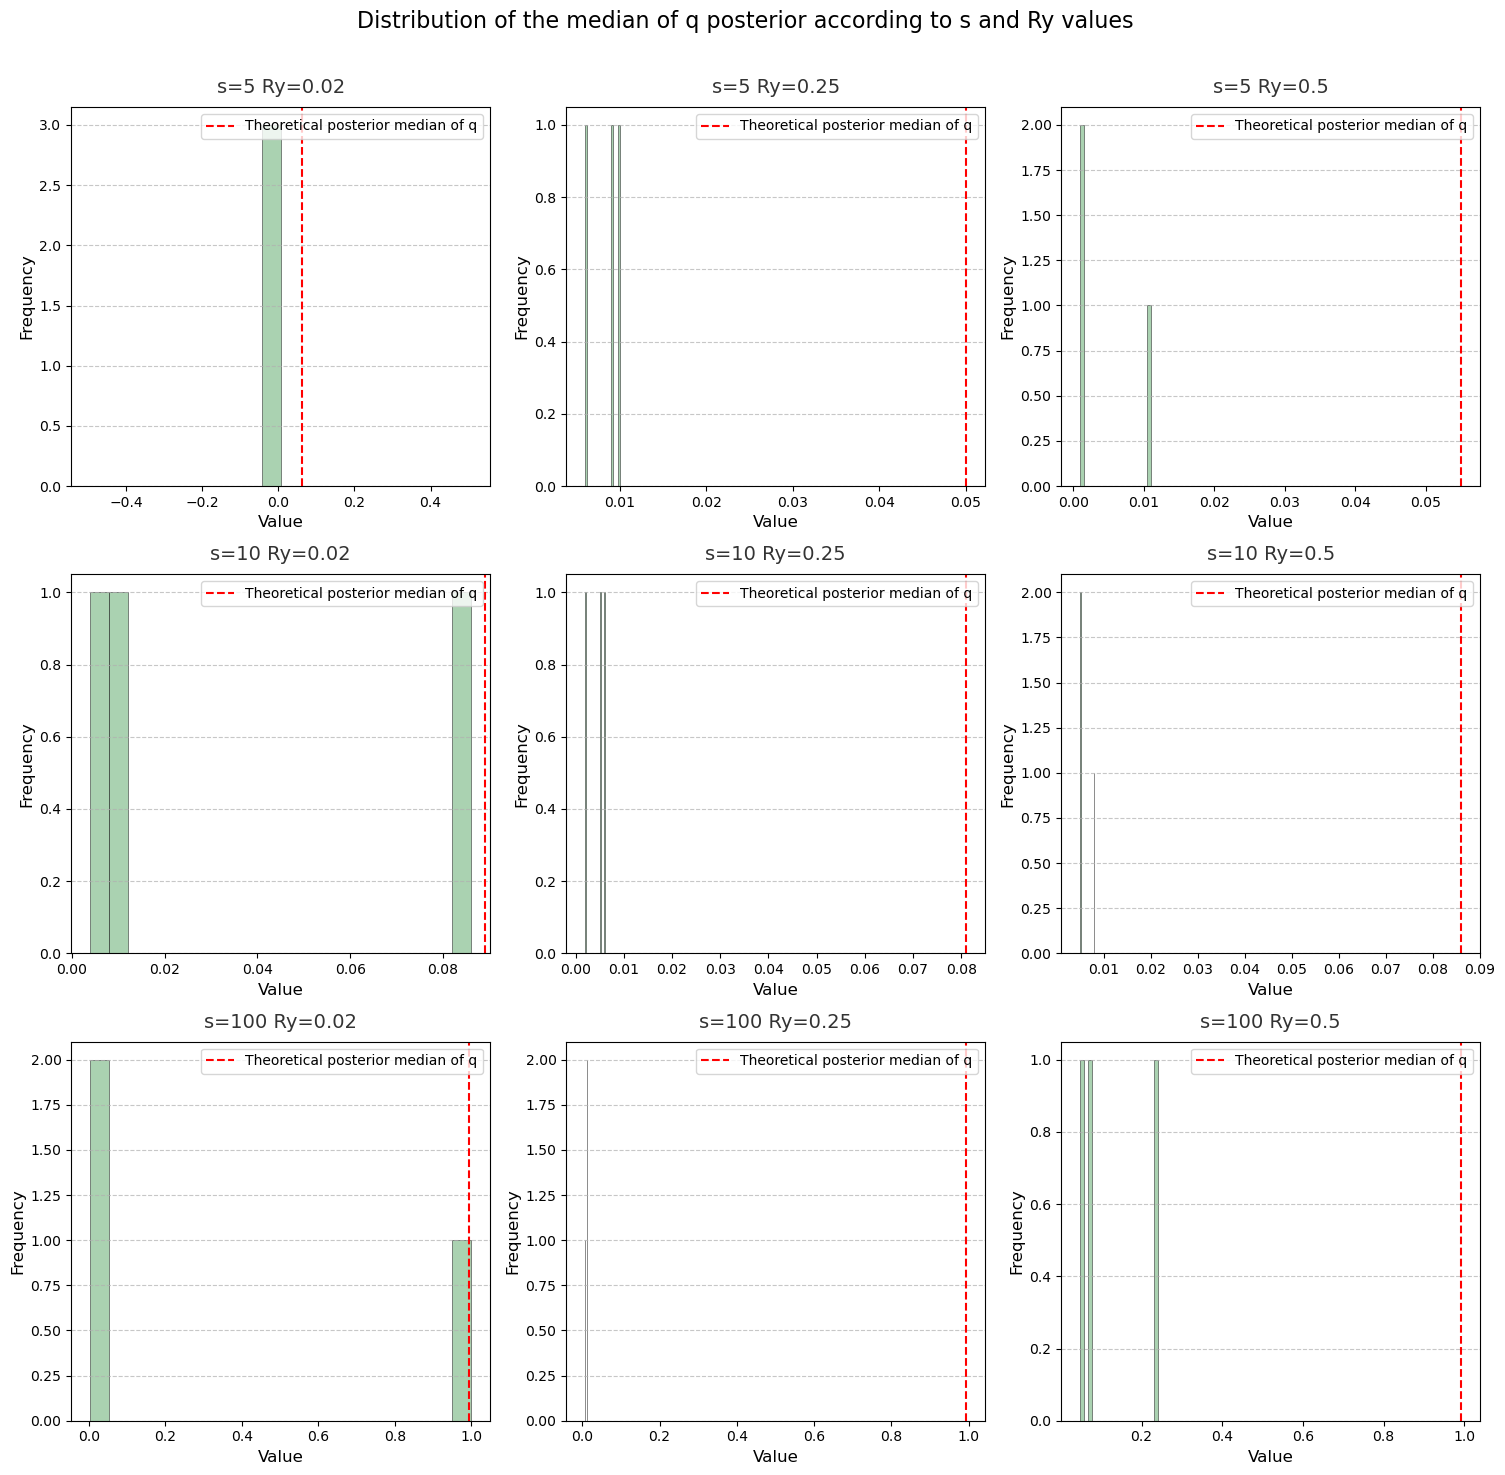

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of the median of q posterior according to s and Ry values', fontsize=16)
axs = axs.flatten()
for i, (key, values) in enumerate(samples_median_q_posterior.items()):
    axs[i].hist(values, bins=20, color='#86bf91', edgecolor='#1a1a1a', linewidth=0.5, alpha=0.7)
    axs[i].set_title(key, fontsize=14, color='#333333', pad=10)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    axs[i].legend(loc='upper right', fontsize='medium')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

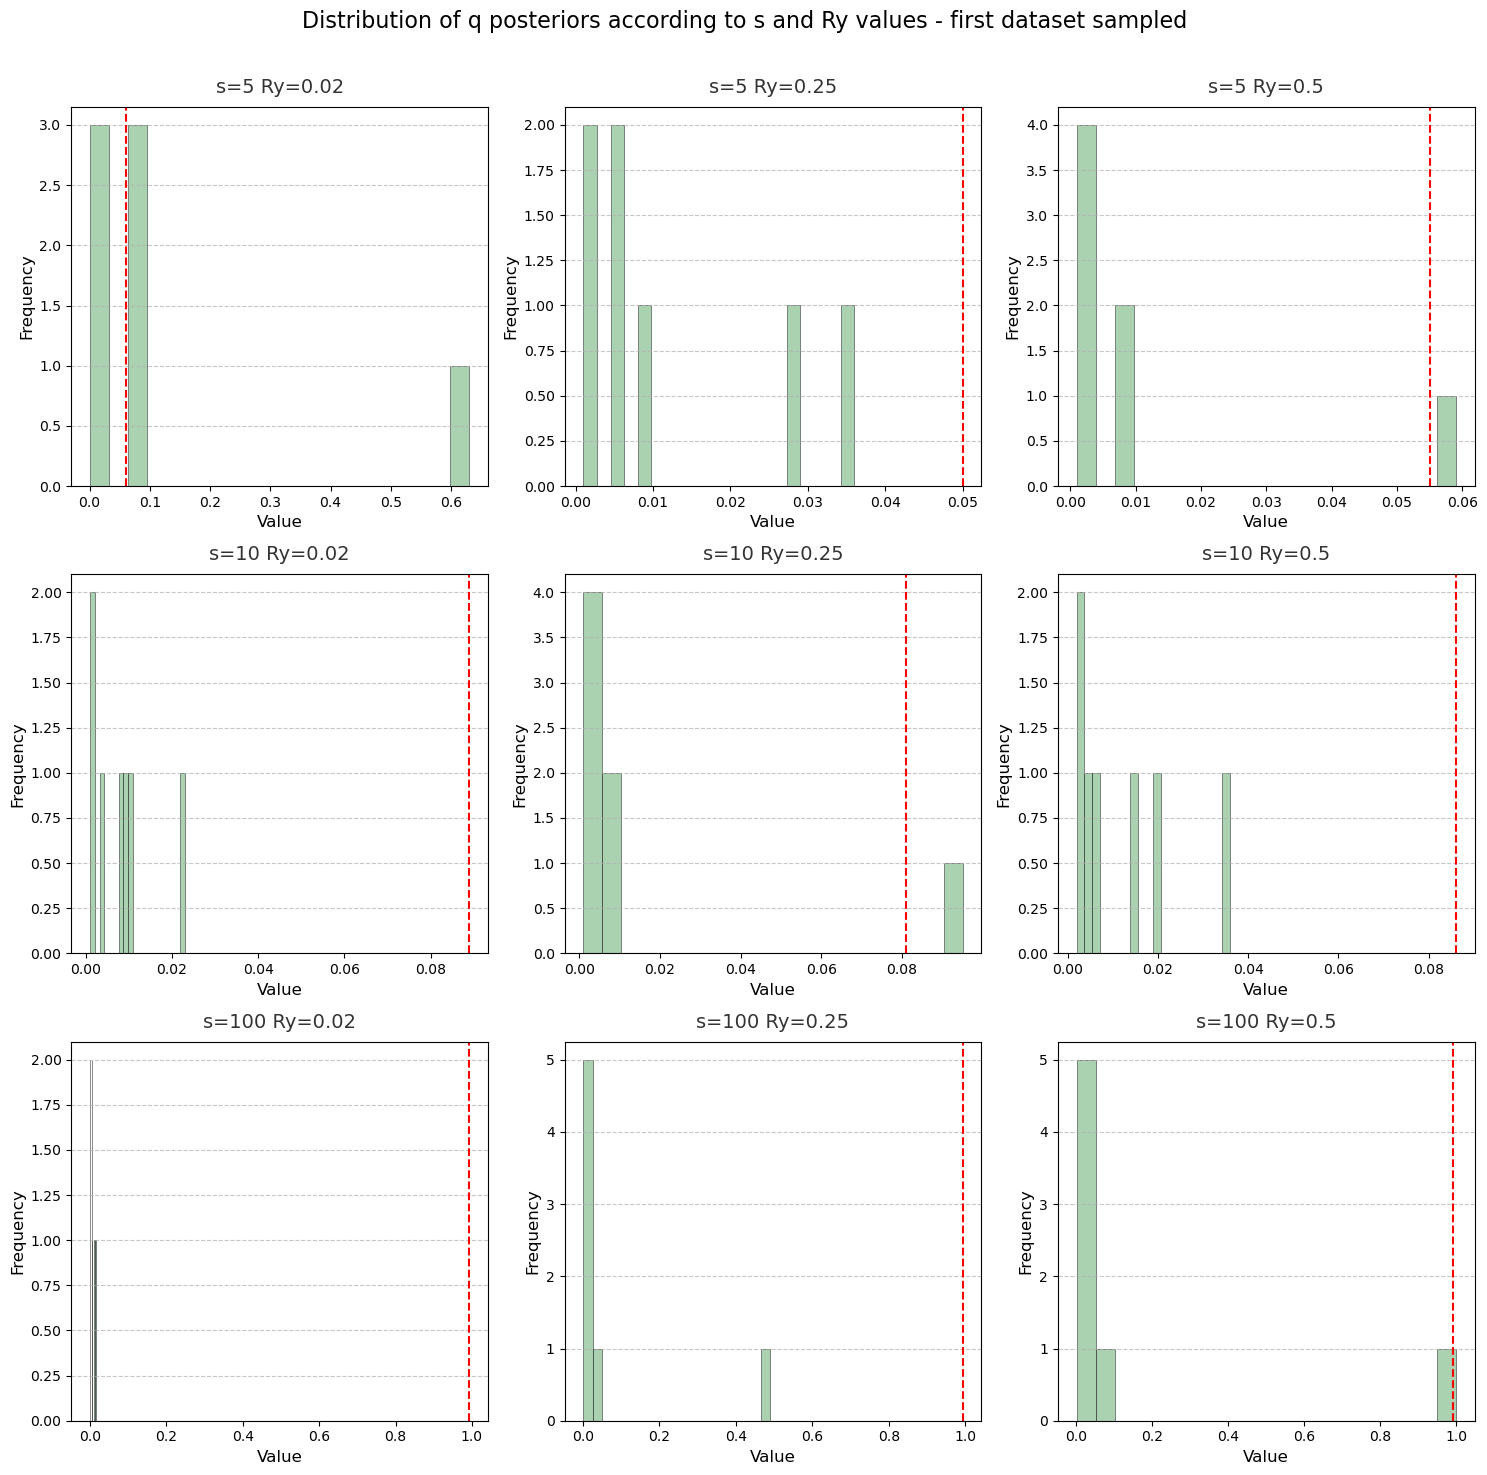

In [ ]:
q_posteriors_first_dataset=q_posteriors_by_dataset["Dataset 1"]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of q posteriors according to s and Ry values - first dataset sampled', fontsize=16)
axs = axs.flatten()
for i, (key, values) in enumerate(q_posteriors_first_dataset.items()):
    axs[i].hist(values, bins=20, color='#86bf91', edgecolor='#1a1a1a', linewidth=0.5, alpha=0.7)
    # theoretical_median=theoretical_median_by_dataset['Dataset 1'][key]
    # axs[i].axvline(x=theoretical_median, color='red', linestyle='--', label="Theoretical posterior median of q")
    axs[i].set_title(key, fontsize=14, color='#333333', pad=10)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
def posterior_theoretical_median_q(data, grid):
    """Theoretical median of q according to the posterior marginal law computed on a specific dataset

    Args:
        data (np.ndarray): Array containing the data.
        grid (np.ndarray): 2D array representing the parameter grid.

    Returns:
        float: theoretical posterior median of q
    """
    vect_q_density=get_q_density(data, grid)
    FDR=0

    for i, pi in enumerate(vect_q_density):
        FDR += pi
        if FDR >=0.5:
            break
    return np.unique(grid[:,1])[i]